# SpectrogramMatrix Tutorial

This notebook introduces the basic usage of the `SpectrogramMatrix` class in `gwexpy`.

`SpectrogramMatrix` is a class designed to efficiently handle multiple `gwpy.spectrogram.Spectrogram` objects as a 3-dimensional matrix (Batch, Time, Frequency). It inherits from `numpy.ndarray`, enabling fast numerical computation and seamless integration with PyTorch/CuPy.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.timeseries import TimeSeriesMatrix

# Fix random seed
np.random.seed(42)

/home/washimi/work/gwexpy/.venv-docs-exec/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## 1. Data Preparation


<SeriesMatrix shape=(2, 2, 512) rows=('r0', 'r1') cols=('c0', 'c1')>

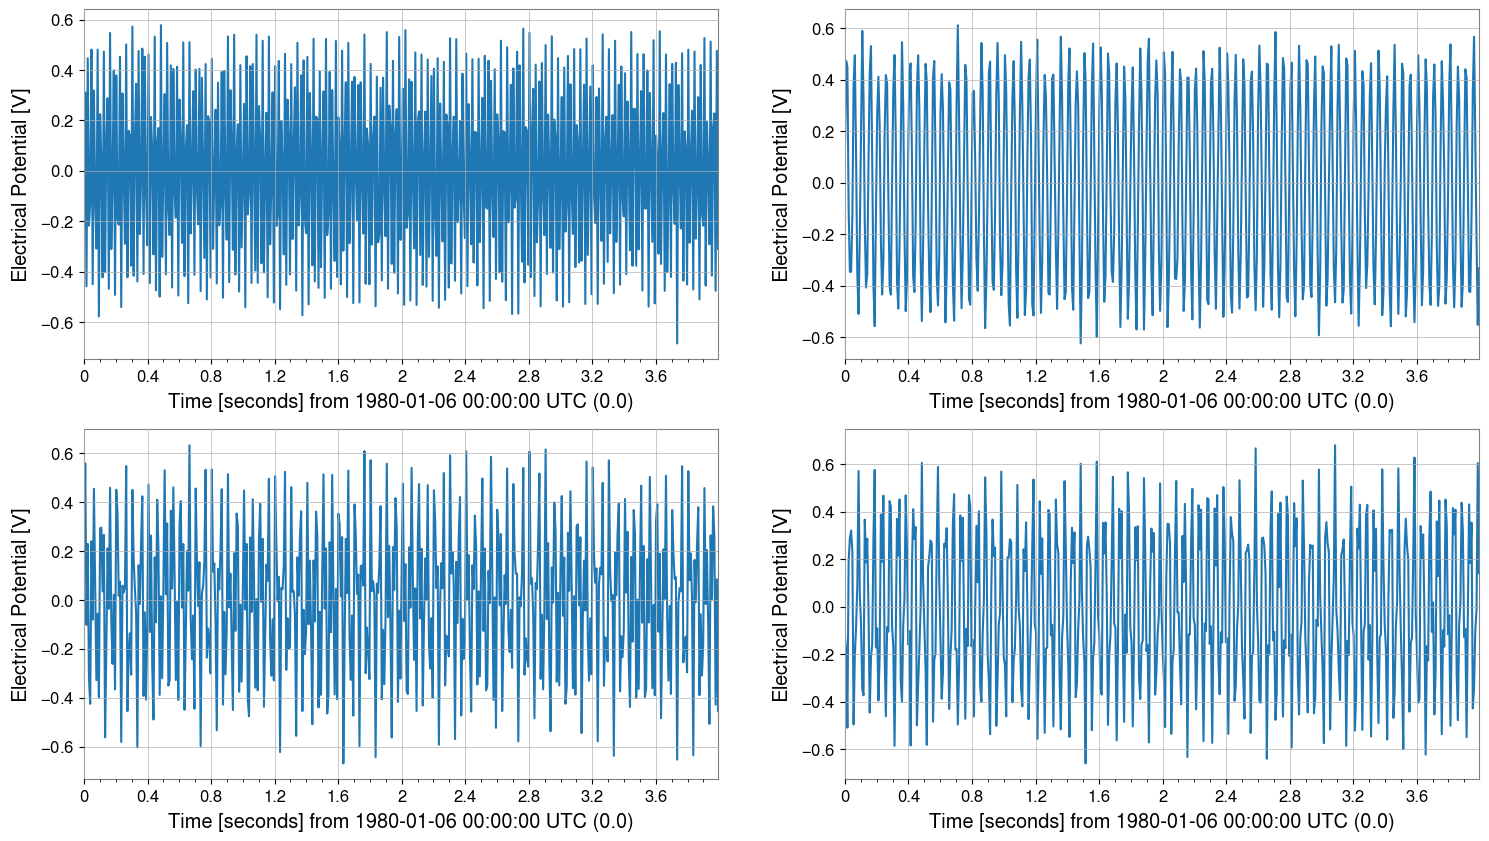

In [2]:
rng = np.random.default_rng(0)

# Sample configuration
n = 512
dt = (1 / 128) * u.s
t0 = 0 * u.s

t = (np.arange(n) * dt).to_value(u.s)

tone50 = np.sin(2 * np.pi * 50 * t)
tone20 = np.sin(2 * np.pi * 20 * t + 0.3)

data = np.empty((2, 2, n), dtype=float)
data[0, 0] = 0.5 * tone50 + 0.05 * rng.normal(size=n)
data[0, 1] = 0.5 * tone20 + 0.05 * rng.normal(size=n)
data[1, 0] = 0.3 * tone50 + 0.3 * tone20 + 0.05 * rng.normal(size=n)
data[1, 1] = 0.2 * tone50 - 0.4 * tone20 + 0.05 * rng.normal(size=n)

units = np.full((2, 2), u.V)
names = [["ch00", "ch01"], ["ch10", "ch11"]]
channels = [["X:A", "X:B"], ["Y:A", "Y:B"]]

tsm = TimeSeriesMatrix(
    data,
    dt=dt,
    t0=t0,
    units=units,
    names=names,
    channels=channels,
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="demo",
)

display(tsm)
tsm.plot()
plt.show()

## 2. Creating a SpectrogramMatrix

Using the `to_matrix()` method of `SpectrogramList`, all spectrograms are stacked into a single `SpectrogramMatrix`.
This yields a 3-dimensional array with shape `(N, Time, Frequency)`.

Type: <class 'gwexpy.spectrogram.matrix.SpectrogramMatrix'>
Shape: (2, 2, 2, 33)


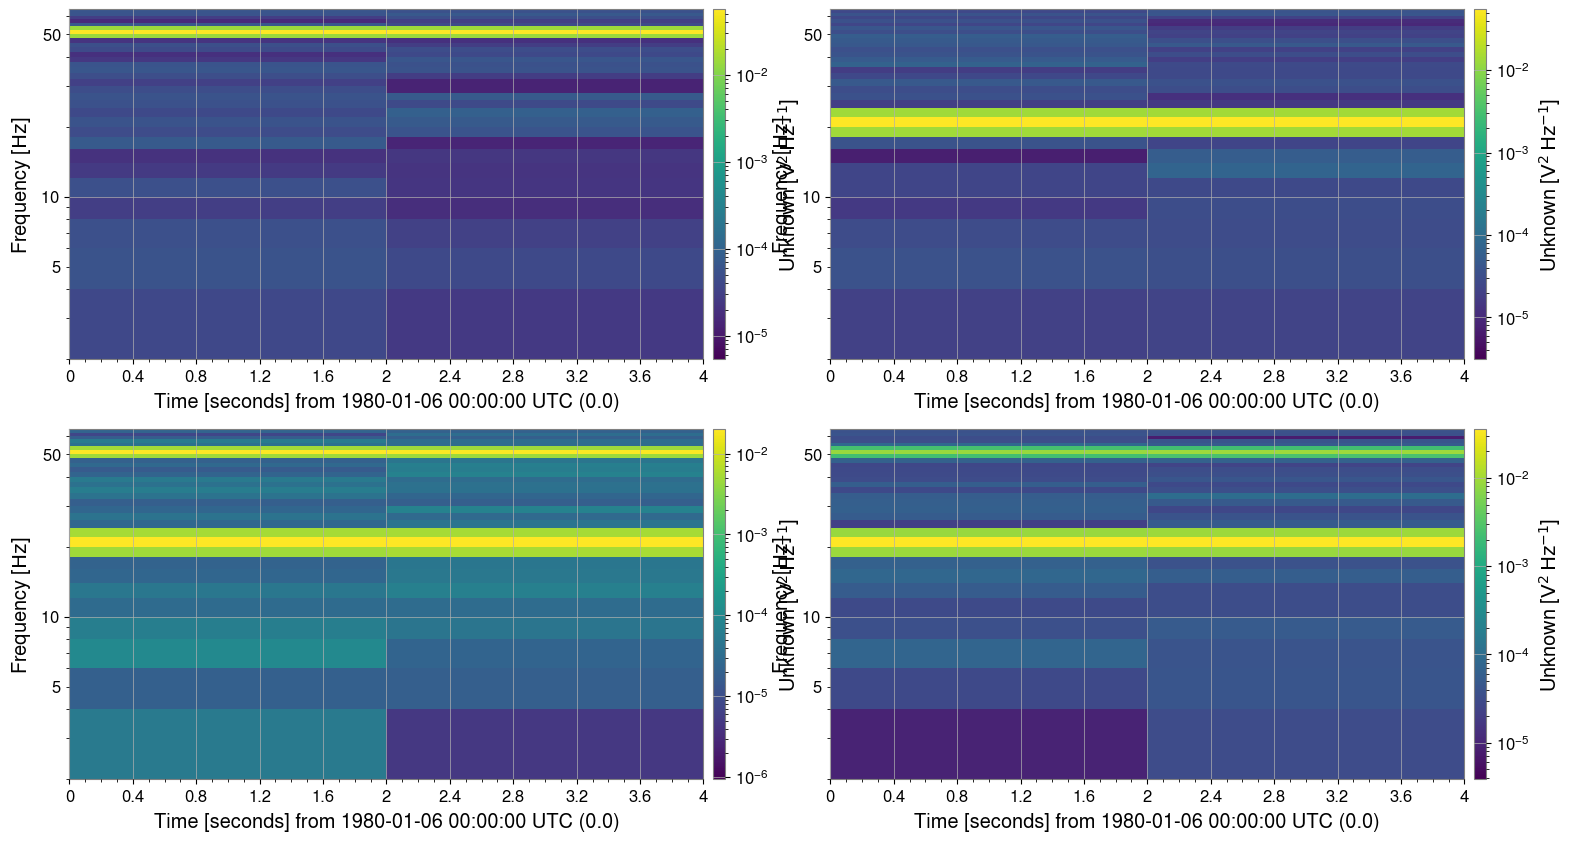

In [3]:
spec_matrix = tsm.spectrogram(2, fftlength=0.5, overlap=0.25)

print("Type:", type(spec_matrix))
print("Shape:", spec_matrix.shape)  # (Batch, Time, Freq)
spec_matrix.plot();

### Accessing Attributes
`SpectrogramMatrix` preserves information about the time and frequency axes from the original spectrograms.

In [4]:
print("Time axis (first 5):", spec_matrix.times[:5])
print("Freq axis (first 5):", spec_matrix.frequencies[:5])
print("Unit:", spec_matrix.unit)

Time axis (first 5): [0. 2.] s
Freq axis (first 5): [0. 2. 4. 6. 8.] Hz
Unit: V2 / Hz


## 3. Numerical Computation and Statistics

Since `SpectrogramMatrix` is a subclass of `numpy.ndarray`, NumPy functions can be applied directly.
Methods like `mean()` are also available.

For example, let's calculate the average spectrogram across all channels (batch dimension).

In [5]:
# Take the mean along axis=0 (Batch axis)
mean_spectrogram_data = spec_matrix.mean(axis=0)

print("Mean Data Shape:", mean_spectrogram_data.shape)
# The result is a 2D array of shape (Time, Freq)

Mean Data Shape: (2, 2, 33)


## 4. Plotting

Use the `plot()` method to visualize the data.
When calling `plot()` on 3-dimensional data (Batch, Time, Freq), by default the **mean across the batch dimension** is plotted.
This is useful for examining the average characteristics across multiple events.

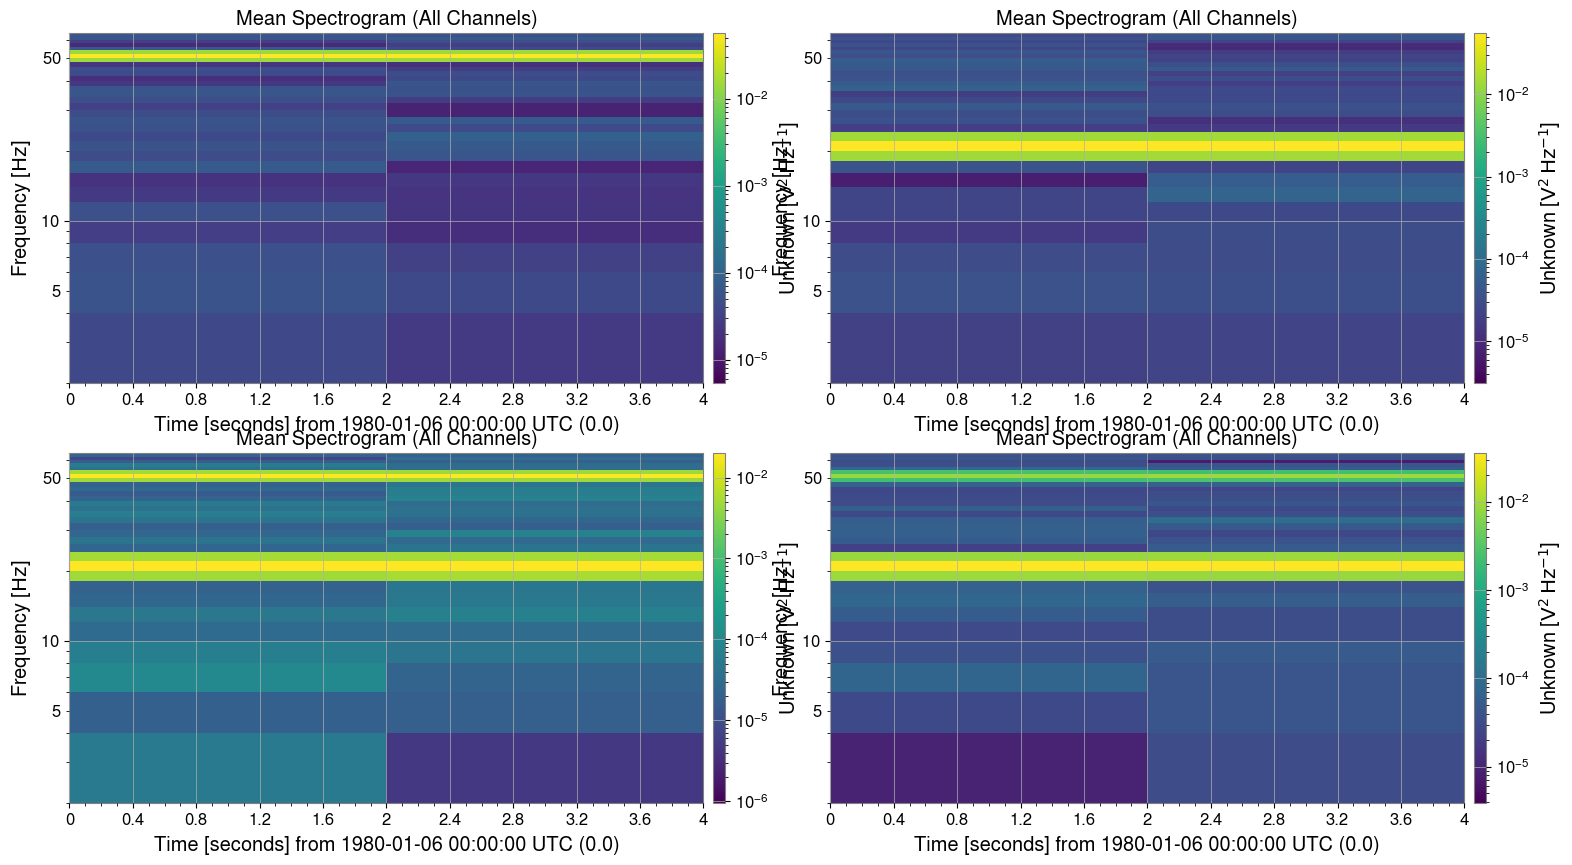

In [6]:
plot = spec_matrix.plot(title="Mean Spectrogram (All Channels)")
plt.show()

To plot only a specific channel, specify an index using the `monitor` argument.

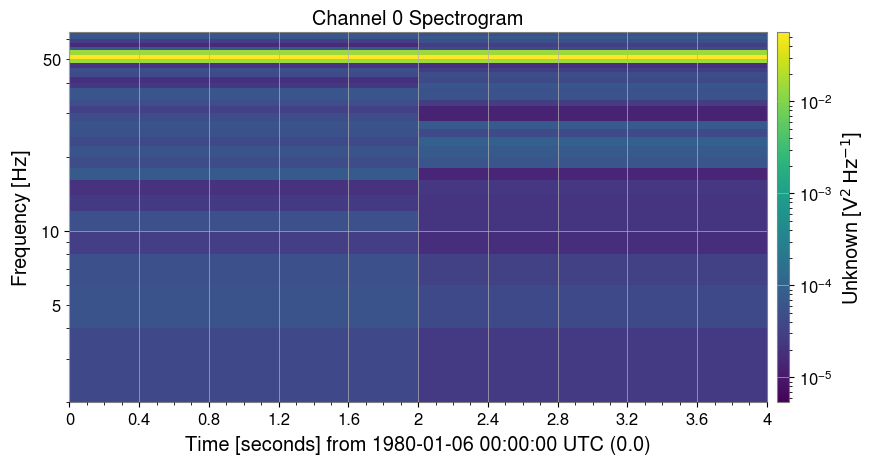

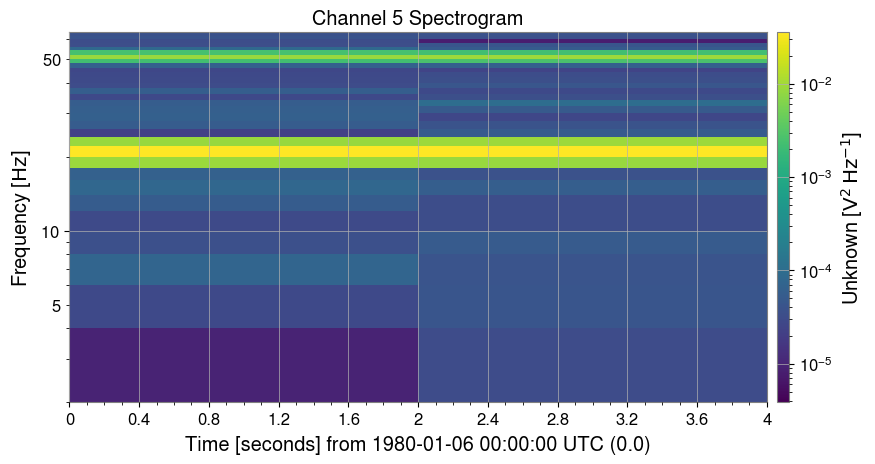

In [7]:
# Plot the first channel (Channel_0)
plot0 = spec_matrix.plot(monitor=0, title="Channel 0 Spectrogram")
plot0.show()

# Plot the fifth channel (Channel_5)
plot5 = spec_matrix.plot(monitor=3, title="Channel 5 Spectrogram")
plot5.show()

## 5. Integration with External Libraries

For machine learning or GPU computing, the data can be easily converted to PyTorch or CuPy tensors.

In [8]:
# Conversion to PyTorch Tensor
try:
    import torch

    _ = torch
    torch_tensor = spec_matrix.to_torch()
    print("PyTorch Tensor:", type(torch_tensor))
    print("Shape:", torch_tensor.shape)
except ImportError:
    print("PyTorch is not installed.")

# Conversion to CuPy Array (if CUDA environment is available)
from gwexpy.interop import is_cupy_available

if is_cupy_available():
    cupy_array = spec_matrix.to_cupy()
    print("CuPy Array:", type(cupy_array))
    print("Shape:", cupy_array.shape)
else:
    print("CuPy is not installed or GPU driver is not working.")

PyTorch is not installed.
CuPy is not installed or GPU driver is not working.


## Summary

- **`SpectrogramMatrix`** can be created using `SpectrogramList.to_matrix()`.
- It holds data as a 3-dimensional array `(Batch, Time, Freq)`.
- Methods like `mean()` and `plot()` make it easy to aggregate and visualize data.
- It serves as a useful intermediate format for passing data to deep learning frameworks via methods like `to_torch()`.